In [1]:
import astra
import numpy as np
import scipy.io 
import skimage.io as io
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
cuda=True

if cuda == True :
    projstr='cuda'
    cfgstr='SIRT_CUDA'
else :
    projstr='strip'
    cfgstr='SIRT'
    
angles = np.linspace(0,np.pi,180,False)

vol_geom = astra.create_vol_geom(256, 256)
proj_geom = astra.create_proj_geom('parallel', 1.0, 384, angles)

In [3]:
# For CPU-based algorithms, a "projector" object specifies the projection
# model used. In this case, we use the "strip" model.
proj_id = astra.create_projector(projstr, proj_geom, vol_geom)

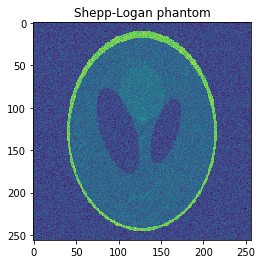

In [4]:
# Create a sinogram from a phantom
import scipy.io
P = scipy.io.loadmat('phantom.mat')['phantom256']
P = P + np.random.normal(0,0.1,size=P.shape)
plt.imshow(P)
plt.title('Shepp-Logan phantom')
plt.show()

In [5]:
sinogram_id, sinogram = astra.create_sino(P, proj_id)

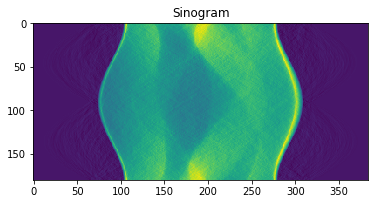

In [6]:
plt.imshow(sinogram)
plt.title('Sinogram')
plt.show()

In [7]:
# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)
proj_id = astra.create_projector('strip', proj_geom, vol_geom)
# Set up the parameters for a reconstruction algorithm using the CPU
# The main difference with the configuration of a GPU algorithm is the
# extra ProjectorId setting.
cfg = astra.astra_dict(cfgstr)
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Available algorithms:
# ART, SART, SIRT, CGLS, FBP

In [8]:
# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run 20 iterations of the algorithm
# This will have a runtime in the order of 10 seconds.
astra.algorithm.run(alg_id, 200)

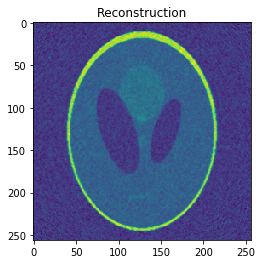

-0.23487417 1.1772085


In [9]:
# Get the result
rec = astra.data2d.get(rec_id)

plt.imshow(rec)
plt.title('Reconstruction')
plt.show()
print(rec.min(),rec.max())

In [10]:
# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)

# Real data tests

Select if CUDA shall be used or not

In [11]:
cuda=True

if cuda == True :
    projstr='cuda'
    cfgstr='SIRT_CUDA'
else :
    projstr='strip'
    cfgstr='SIRT'

Load sinogram

(626, 448)

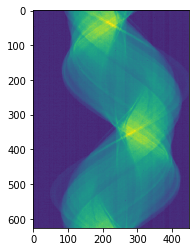

In [12]:
sino=io.imread("woodsino_0200.tif")
plt.imshow(sino)
sino.shape


In [13]:
angles = np.linspace(0,2*np.pi,sino.shape[0],False)

vol_geom = astra.create_vol_geom(sino.shape[1],sino.shape[1])
proj_geom = astra.create_proj_geom('parallel', 1, sino.shape[1], angles)

Center-of-rotation correction (by -29 pixels horizontally)

In [14]:
proj_geom_cor = astra.geom_postalignment(proj_geom,-29)
#proj_geom_cor = proj_geom

In [15]:
sino_id = astra.data2d.link("-sino",proj_geom_cor,sino) # share sinogram array with ASTRA
proj_id = astra.create_projector(projstr, proj_geom_cor, vol_geom)
# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

Set up the parameters for a reconstruction algorithm using the CPU. The main difference with the configuration of a GPU algorithm is the
extra ProjectorId setting.

In [31]:

cfg = astra.astra_dict(cfgstr)
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId']     = sino_id
cfg['ProjectorId']          = proj_id
cfg['option'] = {}
cfg['option']['MinConstraint'] = 0.  # Force solution to be nonnegative.

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

Run N iterations of the algorithm
This will have a runtime in the order of less than a second on a decent GPU. Or many minutes on a CPU.

In [32]:
astra.algorithm.run(alg_id, 200)

Get the result and show the slice

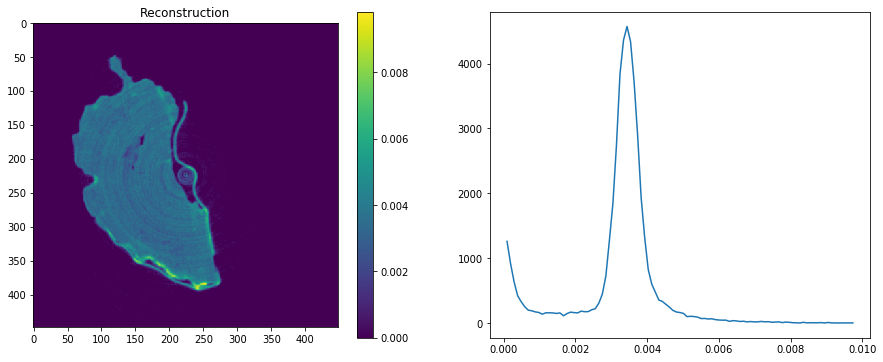

In [33]:
rec = astra.data2d.get(rec_id)
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.imshow(rec,cmap='viridis')
plt.title('Reconstruction')
plt.colorbar()
plt.subplot(1,2,2)
h,a=np.histogram(np.squeeze(rec),bins=100)
plt.plot(a[1:-1],h[1:])

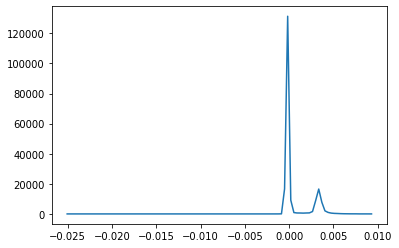